# Urban noise detection using KNN K-nearest neighbours

In [137]:
!pip install --upgrade pip librosa resampy pandas matplotlib tqdm tensorflow plotly

In [138]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import warnings
import pickle


import numpy as np
from tqdm import tqdm
import soundfile as sf

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import plotly.express as px

warnings.filterwarnings('ignore')

# Display Meta file

In [139]:
metadata = pd.read_csv('UrbanSound8K.csv')
metadata.head(15)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


## Display an audio in waveform

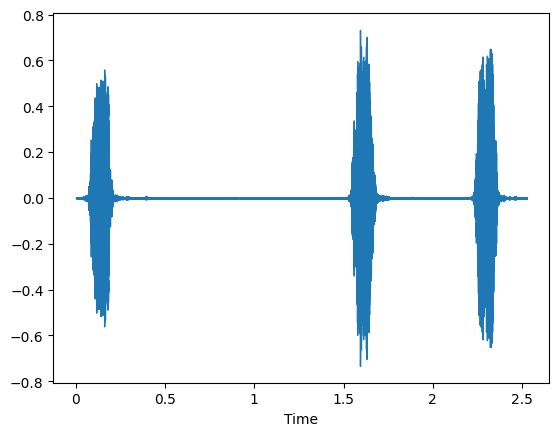

In [140]:
# Load the audio file
filename="fold8/103076-3-0-0.wav"
data, sample_rate = librosa.load(filename)

# Plot the waveform
librosa.display.waveshow(data,sr=sample_rate)

# Play the audio
ipd.Audio(filename)


In [141]:
# def features_extract(file):
#     sample,sample_rate = librosa.load(file,res_type='kaiser_fast')
#     feature = librosa.feature.mfcc(y=sample,sr=sample_rate,n_mfcc=50)
#     scaled_feature = np.mean(feature.T,axis=0)
#     return scaled_feature

# extracted_features = []

# audio_path ='/workspace/'
# for index_num,row in tqdm(metadata.iterrows()):
#     file_name = os.path.join(os.path.abspath(audio_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
#     final_class_labels = row['class']   
#     data = features_extract(file_name)    
#     extracted_features.append([data,final_class_labels])

## Read features from pickle file to cut down training time from 20 minutes to milli-seconds

In [142]:
def read_features_from_pickle(fname: str):
    features = []
    in_file = os.path.join(os.path.abspath("."), fname)

    with open(in_file, "rb") as f:
        features = pickle.load(f)

    return features

extracted_features = read_features_from_pickle("extracted_features.pickle")

In [143]:
### converting extracted_features to Pandas dataframe
extracted_features = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520653, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [144]:
### Split the dataset into independent and dependent dataset
X = np.array(extracted_features['feature'].tolist())
y = np.array(extracted_features['class'].tolist())

In [145]:
X.shape

(8732, 40)

## Split audio data into test and train set 

In [146]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train the classifier

In [147]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## Measure accuracy

In [148]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9015116811726981


## Perform cross-validation 

In [149]:
k_values = list(range(1, 11))
accuracies = []

# Try out different values of K and evaluate the model's accuracy for each value.
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Output the accuracies for each value of K.
for k, accuracy in zip(k_values, accuracies):
    print("K =", k, "Accuracy =", accuracy)


K = 1 Accuracy = 0.9326614750343564
K = 2 Accuracy = 0.8978469995419148
K = 3 Accuracy = 0.9015116811726981
K = 4 Accuracy = 0.8799816765918461
K = 5 Accuracy = 0.8657810352725607
K = 6 Accuracy = 0.8575355016032982
K = 7 Accuracy = 0.8515803939532753
K = 8 Accuracy = 0.8483737975263399
K = 9 Accuracy = 0.8378378378378378
K = 10 Accuracy = 0.8305084745762712


## Plot cross-validations results

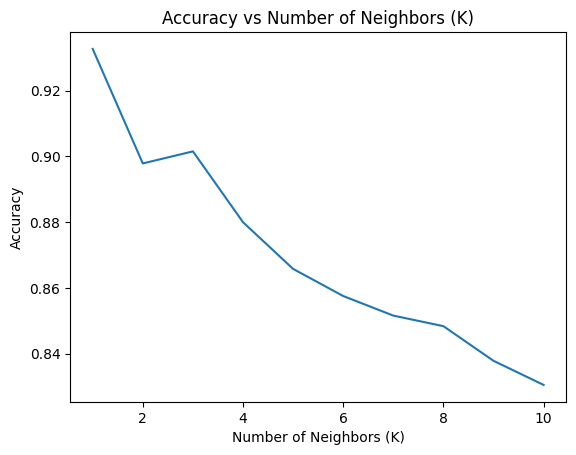

In [150]:
# Visualization of the accuracy dependency on the value of K
plt.plot(k_values, accuracies)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neighbors (K)')
plt.show()

## Conclusion

The possible max accuracy of K-Nearest neighbours is: <b>0.9015116811726981</b> with number of neighbours k = 3, and test_size=0.25